
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)





[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/13.0.Suspicious_Activity_Reports_NER.ipynb)

#🎬 Installation

In [ ]:
! pip install -q johnsnowlabs

##🔗 Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, finance,visual

# nlp.install(force_browser=True)

##🔗 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install(visual=True)

In [ ]:
! pip install -U Pillow==9.4.0

#📌 Starting

In [ ]:
from johnsnowlabs import finance,nlp,visual
spark = nlp.start(visual=True)

# Suspicious Activity Reports


Suspicious Activity Reports (**SARs**) are reports that **financial institutions** are required to file with the Financial Crimes Enforcement Network (**FinCEN**) of the US Department of the Treasury when they detect a transaction or series of transactions that appear to be suspicious or potentially related to money laundering, terrorist financing, or other criminal activities.

SARs are filed by a variety of **financial institutions**, including banks, credit unions, broker-dealers, and money services businesses. They are intended to assist law enforcement agencies in identifying and investigating financial crimes, as well as to help financial institutions comply with anti-money laundering (AML) and counter-terrorist financing (**CTF**) regulations.

The information contained in SARs may include details about the customer, the transaction, and the reason for the suspicion, as well as any supporting documentation. Financial institutions are prohibited from disclosing the filing of a SAR to the customer or anyone else, as doing so could compromise ongoing investigations.

## Visual and Finance NLP Used to Extract Entities from SAR Text and Generate Summaries
Here, we will use a combination of Visual NLP and Finance NLP to extract and analyze information from Suspicious Activity Reports (SARs) related to financial transactions.
Firstly, we will use Visual NLP to extract the text from SARs. Then, we will apply Finance NLP techniques to identify the relevant entities mentioned in the extracted text, such as individuals, organizations, and financial instruments.

Once the relevant entities have been identified, we will use Finance Summarizer to generate summaries of the SARs. These summaries will provide a high-level overview of the financial transactions and activities mentioned in the SARs, making it easier to identify potential financial crimes or patterns of suspicious activity.

Finally, we will plot the identified entities on a graph to visualize the connections and relationships between them.

### Visual NLP On Suspicious Activity Reports

In [ ]:
from johnsnowlabs import nlp, finance, viz,visual

import os
import sys
import time
import json
import functools 
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import spatial

In [ ]:
import os
import sys
import time
import json
import functools 
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import spatial

import pyspark.sql.functions as F
import pkg_resources
     

In [ ]:

!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/sar.png



In [ ]:
image_path = "sar.png"

image_example_df = spark.read.format("binaryFile").load(image_path)

visual.display_images(visual.BinaryToImage().transform(image_example_df))

In [ ]:
binary_to_image = visual.BinaryToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = visual.ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(8)
      #.setKeepLayout(True) 
      # \# to preserve the layout of the input

image_to_text_pipeline = nlp.PipelineModel(stages=[
    binary_to_image,
    ocr
])

In [ ]:
result = image_to_text_pipeline.transform(image_example_df)
result.select("pagenum", "text", "confidence").show()

result.printSchema()

In [ ]:
extracted_text = "".join([row.text for row in result.select("text").collect()])


In [ ]:
print(extracted_text)

### Finance NLP on the extracted text

**Let's build a pipeline!**

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
  .setInputCols("document")\
  .setOutputCol("token")

tokenClassifier = finance.BertForTokenClassification.pretrained("finner_bert_suspicious_activity_reports", "en", "finance/models")\
  .setInputCols("token", "document")\
  .setOutputCol("label")\
  .setCaseSensitive(True)

ner_converter = nlp.NerConverter()\
        .setInputCols(["document","token","label"])\
        .setOutputCol("ner_chunk")

pipeline =  nlp.Pipeline(stages=[
  documentAssembler,
  tokenizer,
  tokenClassifier,
    ner_converter
    ]
)

import pandas as pd

p_model = pipeline.fit(spark.createDataFrame(pd.DataFrame({'text': ['']})))

finner_bert_suspicious_activity_reports download started this may take some time.
[ | ][OK!]

In [ ]:
df = spark.createDataFrame([[extracted_text]]).toDF("text")

result = p_model.transform(df)

In [ ]:
df = spark.createDataFrame([[extracted_text]]).toDF("text")

result = p_model.transform(df)

In [ ]:
import pyspark.sql.functions as F
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label"),
              F.expr("cols['1']['confidence']").alias("confidence")).show(truncate=False)

+--------------------+------------------+----------+
chunk |ner_label |confidence|
+--------------------+------------------+----------+
Suspicious |SUSPICIOUS_KEYWORD|0.99331987|
Suspicious |SUSPICIOUS_KEYWORD|0.99203336|
Business Loan |SUSPICIOUS_ACTION |0.92259026|
Suspicious |SUSPICIOUS_KEYWORD|0.97340876|
loan application |SUSPICIOUS_ACTION |0.9451194 |
large |SUSPICIOUS_ACTION |0.5627501 |
sum of money |SUSPICIOUS_ACTION |0.6471868 |
suspicions |SUSPICIOUS_KEYWORD|0.9680406 |
fraudulent |SUSPICIOUS_KEYWORD|0.99188185|
documentation |SUSPICIOUS_ITEMS |0.45694438|
financial statements|SUSPICIOUS_ITEMS |0.98107696|
tax returns |SUSPICIOUS_ITEMS |0.9909848 |
bank statements |SUSPICIOUS_ITEMS |0.98952335|
+--------------------+------------------+----------+

In [ ]:
light_model = nlp.LightPipeline(p_model)

light_result = light_model.fullAnnotate(extracted_text)

chunks = []
entities = []
sentence= []
begin = []
end = []

for n in light_result[0]['ner_chunk']:
        
    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    sentence.append(n.metadata['sentence'])
    
    

df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                   'sentence_id':sentence, 'entities':entities})

df.head(20)

Out[16]:

,chunks,begin,end,sentence_id,entities
0,Suspicious,0,9,0,SUSPICIOUS_KEYWORD
1,Suspicious,101,110,0,SUSPICIOUS_KEYWORD
2,Business Loan,132,144,0,SUSPICIOUS_ACTION
3,Suspicious,150,159,0,SUSPICIOUS_KEYWORD
4,loan application,213,228,0,SUSPICIOUS_ACTION
5,large,236,240,0,SUSPICIOUS_ACTION
6,sum of money,243,254,0,SUSPICIOUS_ACTION
7,suspicions,341,350,0,SUSPICIOUS_KEYWORD
8,fraudulent,364,373,0,SUSPICIOUS_KEYWORD
9,documentation,425,437,0,SUSPICIOUS_ITEMS


**Visualizing the results**

In [ ]:
# from sparknlp_display import NerVisualizer

visualiser = viz.NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

Suspicious SUSPICIOUS_KEYWORD Activity Report Incident Description — Date 02/01/2017 Location’ Area Affected: Suspicious SUSPICIOUS_KEYWORD Activity Retated to Business Loan SUSPICIOUS_ACTION Suspicious SUSPICIOUS_KEYWORD Activity: ‘On May 3rd, ACME Corporation submitted a loan application SUSPICIOUS_ACTION for a large SUSPICIOUS_ACTION sum of money SUSPICIOUS_ACTION . The loan officer noted that the application contained several red flags that raised suspicions SUSPICIOUS_KEYWORD of possible fraudulent SUSPICIOUS_KEYWORD activity. Firstly, the business provided minimal documentation SUSPICIOUS_ITEMS to support their financial statements SUSPICIOUS_ITEMS , such as tax returns SUSPICIOUS_ITEMS or bank statements SUSPICIOUS_ITEMS . Secondly, the business listed a residential address as their place of business, which appeared to be a private residence. Additionally, the business provided inconsistent information regarding their ownership structure and the intended use of the loan proceeds. Further investigation revealed that the business had no visible online presence, including a lack of a website, social media accounts, or business reviews. The loan officer also discovered that the business had ‘only been in operation for a short period, despite their claims of significant revenue and growth. Based on these findings, it is suspected that ACME Corporation may be engaging in fraudulent activity and using the loan to perpetrate such activity. Therefore, we recommend that this loan application be denied, and further investigation be conducted to determine if any additional suspicious activity has occurred. Suspected Person or Party XYZ Private Limited Address oF Affiliation 600 Townsend St., Suite 200, San Francisco, CA. Plone

## Now let's use SparkNLP's new Financial Summarizer annotator to summarize and understand the suspicious activity.

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("documents")

flant5 = finance.Summarizer().pretrained('finsum_flant5_base','en','finance/models')\
    .setInputCols(["documents"])\
    .setOutputCol("summary")\
    .setMaxNewTokens(1000)

pipeline = nlp.Pipeline(stages=[document_assembler, flant5])

data = spark.createDataFrame([[extracted_text]]).toDF("text")

results = pipeline.fit(data).transform(data)

results.select("summary.result").show(truncate=False)

In [ ]:
df = results.selectExpr("documents.result as Document","summary.result as Summary").toPandas()
# df.rename(columns = {'result':'Text','result':'Summary'},inplace=True)
df

,Document,Summary
0,"[‘On May 3rd, ACME Corporation submitted a loa...",[ACME Corporation submitted a loan application...


Let's take a look at the summary of suspicious activity.

In [ ]:
for i,j in df.iterrows():
  print(f"SAR Report:\n\n {j['Document'][0]}\n\n")
  print(f"Summary Of The Report: \n\n{j['Summary'][0]}")


SAR Report:

 ‘On May 3rd, ACME Corporation submitted a loan application for a large

sum of money. The loan officer noted that the application contained
several red flags that raised suspicions of possible fraudulent activity.

Firstly, the business provided minimal documentation to support their
financial statements, such as tax returns or bank statements. Secondly,
the business listed a residential address as their place of business, which
appeared to be a private residence. Additionally, the business provided
inconsistent information regarding their ownership structure and the
intended use of the loan proceeds.

Further investigation revealed that the business had no visible online
presence, including a lack of a website, social media accounts, or
business reviews. The loan officer also discovered that the business had
‘only been in operation for a short period, despite their claims of significant
revenue and growth.

Based on these findings, it is suspected that ACME Corporation m

## Now Let's create a graph and look at the **text** that has been labelled as `SUSPICIOUS_KEYWORD`,  `SUSPICIOUS_ACTION` or `SUSPICIOUS_ITEMS`.

['DOCUMENT', 'SUSPICIOUS_KEYWORD', 'SUSPICIOUS_ACTION', 'SUSPICIOUS_ITEMS', 'Suspicious', 'Business Loan', 'loan application', 'large', 'sum of money', 'suspicions', 'fraudulent', 'documentation', 'financial statements', 'tax returns', 'bank statements']
[('DOCUMENT', 'SUSPICIOUS_KEYWORD'), ('DOCUMENT', 'SUSPICIOUS_ACTION'), ('DOCUMENT', 'SUSPICIOUS_ITEMS'), ('SUSPICIOUS_KEYWORD', 'Suspicious'), ('SUSPICIOUS_KEYWORD', 'suspicions'), ('SUSPICIOUS_KEYWORD', 'fraudulent'), ('SUSPICIOUS_ACTION', 'Business Loan'), ('SUSPICIOUS_ACTION', 'loan application'), ('SUSPICIOUS_ACTION', 'large'), ('SUSPICIOUS_ACTION', 'sum of money'), ('SUSPICIOUS_ITEMS', 'documentation'), ('SUSPICIOUS_ITEMS', 'financial statements'), ('SUSPICIOUS_ITEMS', 'tax returns'), ('SUSPICIOUS_ITEMS', 'bank statements')]

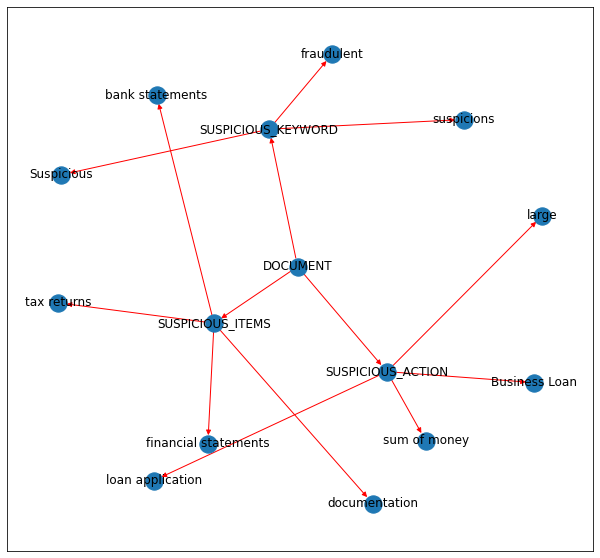

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()

label = 'DOCUMENT'
g.add_node(label)
for i, r in enumerate(light_result[0]['ner_chunk']):
  text = r.result
  entity = r.metadata['entity']
  g.add_edge('DOCUMENT',entity) 

for i, r in enumerate(light_result[0]['ner_chunk']):
  text = r.result
  entity = r.metadata['entity']
  g.add_edge(entity,text) 


fig = plt.figure(figsize=(10.5, 10))
ax = fig.gca()
mng = plt.get_current_fig_manager()
print(g.nodes())
print(g.edges())

pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos, edge_color='r', arrows = True)
plt.show()